In [27]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [28]:
from bs4 import BeautifulSoup
import re
from uuid import uuid4

In [29]:
class Crawler:

    def get_html(self):
        pass

    def get_card_info(self):
        pass

    def get_links(self, page):
        pass

In [61]:
class CrawlerEda(Crawler):

    def get_html(self, page):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        url = f"https://eda.ru/recepty?page={page}"
        #browser.implicitly_wait(30)
        browser.get(url)
        wait = WebDriverWait(browser, 10)
        soup = BeautifulSoup(browser.page_source, 'html.parser')
        return soup

    def get_card_info(self, link):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        action = ActionChains(browser)
        count = 0

        #linker = linkers[number]['link']
        #browser.get(linker)
        wait = WebDriverWait(browser, 10)
        soup_card = BeautifulSoup(browser.page_source, 'html.parser')
        return soup_card

    def get_soup(self, url):
        return BeautifulSoup(requests.get(url).text, "html.parser")

    def get_links(self,first_page, last_page):
        links = []
        for i in range(first_page, last_page):
            html = CrawlerEda().get_html(i)
            links.extend(ParserEda(html).get_cards())
            #print(links)
        return links

In [31]:
class Parser:

    def __init__(self, html):
        self.html = html

    def get_cards(self):
        pass

    def __get_ingredients(self):
        pass

    def __get_calories(self):
        pass

    def __get_manual(self):
        pass

    def __get_category(self):
        pass

    def get_recipe(self):
        pass

In [56]:
class ParserEda(Parser):

    def get_cards(self):
        linkers = []
        for recipe in self.html.findAll('div', class_='emotion-1f6ych6'):
            try:
                link = "https://eda.ru"+recipe.find('a', class_='emotion-12sjte8').get('href')
                photo = str(recipe.find('img', class_='emotion-1bi124x').get('src')).replace('c180x180', 'c500x500')
                #print(link)
                #print(photo)
                linkers.append(Link(link, photo))
            except AttributeError:
                print("There's no item with that code")
        #print(len(linkers))
        return linkers

    def get_recipe(self):
        print("get_recipe")

        parser = ParserEda(self.html)
        recipe = self.html.find('div', class_='emotion-2k9cfu')

        categories = parser.__get_categories()
        print(categories)

        name_dish = recipe.find('a', class_='emotion-19rdt1j').find('h1', class_='emotion-gl52ge').text
        print(name_dish)

        count_portion = int(re.sub(r'\bпорц[ий|ия|ии]*\b', '', recipe.find('div', class_='emotion-1047m5l').text).strip())
        cook_time = recipe.find('span', class_='emotion-1s54pha').find('span', itemprop_='cookTime').text
        manual = parser.__get_manual()

        time.sleep(2)

        helper = DBHelper()
        helper.create_table('recipe', ['name_dish', 'count_portion', 'cook_time', 'categories', 'manual'])
        helper.insert('recipe', ['name_dish', 'count_portion', 'cook_time', 'categories', 'manual'],
                                [name_dish, count_portion, cook_time, categories, manual ])

        #self, table_name, column_args, arg
        #находим айдишник нужного рецепта
        recipe_ = helper.get('recipe', ['name_dish', 'count_portion'], [name_dish, count_portion])
        id_ = recipe_[0][0]

        ingredients = parser.get_ingredients(id_)

        calories = parser.__get_calories(id_)

        #name_dish, count_portion, cook_time, ingredients, categories, manual

    #autoincrement
    def __get_ingredients(self, id):
        all_ingredients = {}
        name_ingredients = []

        for ing in self.html.findAll('div', class_='emotion-bjn8wh'):
            name_ingredients.append(ing.text)

        for i in range (len(name_ingredients)):
            all_ingredients[name_ingredients[i]] = self.html.findAll('span', class_='emotion-bsdd3p')[i].text

        helper = DBHelper()
        helper.create_table('ingredient', ['name_ingr']) #autoincrement
        #table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params
        helper.create_table('recipe_ingredients', 'id', 'recipe', 'recipe_id', 'id', ['recipe_id', 'ingr_id', 'count'], True) #

        for name in name_ingredients:
            helper.insert('ingredient', ['name_ingr'], [name])

        for i in range (len(name_ingredients)):
            #self, table_name, column_args, args
            ingr_ = helper.get('ingredient', ['name_ingr'], [name_ingredients[i]])
            helper.insert('recipe_ingredients', ['recipe_id', 'ingr_id', 'count'], [id, ingr_[0][0], all_ingredients[ingr_[0][1]]])

        return all_ingredients

    #autoincrement
    def __get_categories(self):
        categories = []

        #дурацкие категории
        bad_categories = ['Главная', 'Проверено «Едой»', 'Пошаговые рецепты', 'Видеорецепты', 'Рецепты с историей']

        for category in self.html.findAll('div', class_='emotion-1f6ych6'):
            if category not in bad_categories:
                categories.append(self.html.findAll('span', class_='emotion-1h6i17m')[j].text)

        #связка с бд, возможно уберу
        helper = DBHelper()
        helper.create_table('category', ['name_cat'])
        for category in categories:
            helper.insert('category', ['name_cat'], [category])

        return categories

    #
    def __get_calories(self, id):
        calories = []

        for j in range(4):
            calories.append(self.html.findAll('div', class_='emotion-8fp9e2')[j].text)

        #связка с бд, возможно уберу
        helper = DBHelper()
        #self, table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params
        helper.create_table('calories', 'recipe_id', 'recipe', 'recipe_id', 'id', ['calories', 'proteins', 'fats', 'carbohydrates'])
        helper.insert('calories', 'recipe_id', id, calories)

        return Calories(calories[0], calories[1], calories[2], calories[3])

    def __get_manual(self):
        manual = ''

        for point in self.html.findAll('span', class_='emotion-1dvddtv'):
            manual += point.text.replace(u'\xa0', u' ') + '\n' + '\n'

        return manual

In [33]:
class Recipe:
    def __init__(self, name_dish, count_portion, cook_time, categories, manual):
        self.name = name_dish
        self.count_portion = count_portion
        self.cook_time = cook_time
        self.categories = categories #id categories
        self.manual = manual

In [34]:
class Category:
    def __init__(self, name_cat):
        self.name = name_cat

In [35]:
class Ingredient:
    def __init__(self, name_ingr):
        self.name = name_ingr

In [36]:
class Calories: #можно взять по айдишнику рецепта
    def __init__(self, calories, proteins, fats, carbohydrates):
        self.calories = calories
        self.proteins = proteins
        self.fats = fats
        self.carbohydrates = carbohydrates

In [37]:
class Link:
    def __init__(self, link, photo):
        self.link = link
        self.photo = photo

In [49]:
class DBHelper:

    def __init__(self, db_name = "recipe.db"):
        self.dbname = f"sqlite3:/{db_name}"
        self.conn = sqlite3.connect(db_name)

    #for link, recipe, ingredient and category
    def create_table(self, table_name, params):
        column = ""
        for i in range(len(params) - 1):
            column = str(params[i]) + " TEXT, "
        column += str(params[len(params) - 1]) + " TEXT "
        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} (id INTEGER PRIMARY KEY AUTOINCREMENT , {column})"
        self.conn.execute(new_table)

        print("Выполнилось")

        self.conn.commit()

    #for calories and recipe_ingredients
    def create_table(self, table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params, auto = False):
        column = ""
        for i in len(params) - 1:
            column += params[i] + " TEXT, "
        column += params[len(params)] + " TEXT "

        foreign_key = f"FOREIGN KEY ({foreign_col})  REFERENCES {foreign_table_name} ({another_foreign_col})"

        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} ({primary_key} INTEGER PRIMARY KEY {('', 'AUTOINCREMENT')[auto == True]} , {column}, {foreign_key})"
        self.conn.execute(new_table)

        print("Выполнилось")

        self.conn.commit()

    def insert(self, table_name, primary_key, primary_value, args):
        arguments = "'"
        for i in range(len(args) - 1):
            arguments += args[i] + "', '"
        arguments += args[len(args) - 1] + "'"
        #print(arguments)

        new_insert = f"INSERT INTO {table_name} SELECT * FROM (SELECT {arguments}) AS tmp " \
                     f"WHERE NOT EXISTS ( SELECT {primary_key} FROM {table_name} WHERE {primary_key} = '{primary_value}'" \
                     f") LIMIT 1"
        self.conn.execute(new_insert)

        print("Выполнилось")

        self.conn.commit()

    def insert(self, table_name, column_args, args):
        arguments = "'"
        for i in range(len(args) - 1):
            arguments += args[i] + "', '"
        arguments += args[len(args) - 1] + "'"
        #print(arguments)

        columns = ""
        for i in range(len(column_args) - 1):
            columns += column_args[i] + ", "
        columns += column_args[len(column_args) - 1]

        new_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({arguments})"

        #try:
        self.conn.execute(new_insert)

        print("Выполнилось")

        self.conn.commit()
        #except

    def print_info(self, table_name):
        new_get = f"SELECT * FROM {table_name}"
        cursor = self.conn.execute(new_get)

        print("Выполнилось")

        return [row for row in cursor]

    def get(self, table_name, column_args, args):
        query = ""
        for i in range(len(column_args) - 1):
            query += column_args[i] + " = '" + args[i] + "' AND "
        query += column_args[len(column_args) - 1] + " = '" + args[len(column_args) - 1] + "'"

        new_get = f"SELECT * FROM {table_name} WHERE {query}"
        cursor = self.conn.execute(new_get)

        print("Выполнилось")

        return [row for row in cursor]

    #def update(self, flat_id, updates):


    #def delete(self, flat_id):


In [39]:
linkers = CrawlerEda().get_links(1, 5)
print(len(linkers))
for i in linkers:
    print(i.id, i.link, i.photo)


KeyboardInterrupt



In [ ]:
DBHelper("recipe.db").create_table("link", ["link", "photo"])

Выполнилось


[('20955',
  'https://eda.ru/recepty/vypechka-deserty/brauni-brownie-20955',
  'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120131082911/130725174021/p_O.jpg'),
 ('18506',
  'https://eda.ru/recepty/zavtraki/sirniki-iz-tvoroga-18506',
  'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120213175531/180415114517/p_O.jpg'),
 ('17614',
  'https://eda.ru/recepty/pasta-picca/spagetti-karbonara-s-krasnym-lukom-17614',
  'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/150615095301/150617154856/p_O.jpg'),
 ('21916',
  'https://eda.ru/recepty/vypechka-deserty/klassicheskaja-sharlotka-21916',
  'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/130813174717/151102203457/p_O.jpg'),
 ('31799',
  'https://eda.ru/recepty/pasta-picca/lazanja-klassicheskaja-s-mjasom-31799',
  'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120131082527/130715011534/p_O.jpg'),
 ('16014',
  'https://eda.ru/recepty/vypechka-deserty/tonkie-blini-
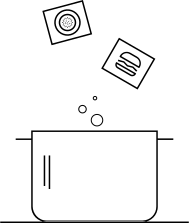

In [64]:
DBHelper("recipe.db").print_info("link")

In [ ]:
for j in range(1):
    linkers = CrawlerEda().get_links(700, 1000)
    print(len(linkers))
    for i in linkers:
        DBHelper().insert("link", "id", i.id, [i.link, i.photo])

In [63]:
#попытка получить рецепт
Parser(CrawlerEda().get_card_info('https://eda.ru/recepty/zavtraki/zavtrak-slovenskiy-91513')).get_recipe()